## Train a Segmentation Model

This notebook trains a segmentation model ([using segmentation-models-pytorch](https://smp.readthedocs.io/en/latest/index.html)) on some [Sentinel-2](https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a) data using crop labels from Radiant Earth's [South Africa Crop Type Competition](http://registry.mlhub.earth/10.34911/rdnt.j0co8q/).

In [1]:
import pystac
import pystac_client
import requests
import shapely.geometry
import datetime
import rioxarray
import pystac_client
import planetary_computer
import stackstac
import torch
import requests
import torch.utils.data
import functools
import rasterio.plot
import numpy as np
import dask

import warnings
warnings.filterwarnings("ignore", "Creating an ndarray from ragged")

We'll use the same STAC catalog for the labels that we used previously.

In [2]:
training_catalog = pystac.read_file(
    "https://esip2021.blob.core.windows.net/esip2021/train/collection.json"
)

And we'll process the data in parallel (on a single machine) using Dask.

In [3]:
from dask.distributed import Client

client = Client()
client.run(
    lambda: warnings.filterwarnings("ignore", "Creating an ndarray from ragged")
)
client

Make sure to open that link in the dashboard or dask labextension.

## Load Training STAC Items

In the last notebook, we worked with a single STAC item / scene for the `labels`. Now we'll grab a batch of them. Just to cut down on the amount of time we're waiting, we'll work with just 100 items.

In [4]:
N_SCENES = 100
links = training_catalog.get_item_links()[:N_SCENES]

@dask.delayed
def get_label_item(link):
    link.resolve_stac_object()
    return link.target

links = [get_label_item(link) for link in links]
%time label_items = dask.compute(*links)

CPU times: user 1.24 s, sys: 120 ms, total: 1.36 s
Wall time: 2.41 s


We can plot the first item:

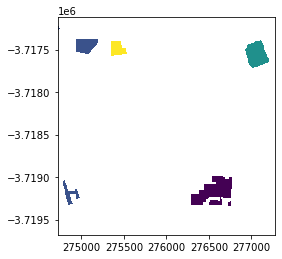

In [5]:
label_item = next(training_catalog.get_all_items())

rasterio.plot.show(
    rasterio.open(label_item.assets["labels"].get_absolute_href())
);

Let's also load the names of each integer label code, which are common across all the items.

In [6]:
labels = requests.get(label_item.assets['raster_values'].get_absolute_href()).json()
labels

{'0': 'No Data',
 '1': 'Lucerne/Medics',
 '2': 'Planted pastures (perennial)',
 '3': 'Fallow',
 '4': 'Wine grapes',
 '5': 'Weeds',
 '6': 'Small grain grazing',
 '7': 'Wheat',
 '8': 'Canola',
 '9': 'Rooibos'}

In [7]:
from ipyleaflet import Map, GeoJSON

data = {
    "type": "FeatureCollection",
    "features": [],
}
for label_item in label_items:
    data["features"].append(label_item.geometry)

    
center = shapely.geometry.shape(
    label_item.geometry
).centroid.bounds[:2][::-1]

m = Map(center=(-32.5, 18.5), zoom=7)
layer = GeoJSON(data=data)

m.add_layer(layer)
m.layout.max_width = "600px"

m

Map(center=[-32.5, 18.5], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

## Load the Sentinel-2 Scenes

Just like before, we'll find a "good" (not too cloudy) Sentinel 2 scene using the Planetary Computer's STAC API. But remeber that we're dealing with a whole bunch of `label` scenes now, rather than just one. Because Sentinel scenes are so much larger that the `labels` chips, we'll do a single search rather than many small ones.

First, let's verify that all the `labels` chips have the same datetime:

In [8]:
# all the labels are from the same datetime
set([label_item.datetime for label_item in label_items])

{datetime.datetime(2017, 8, 1, 0, 0, tzinfo=tzlocal())}

Now, let's compute a big bounding box that covers all the `labels` chips.

In [9]:
import numpy as np

bboxes = np.array([label_item.bbox for label_item in label_items])
mins = bboxes.min(0)
maxes = bboxes.max(0)
bbox = mins[0], mins[1], maxes[2], maxes[3]

### Exercise: Find the STAC items

Find all the STAC items from `sentinel-2-l2a` within that bounding box for 31 days before and after the labels were created. Look back at our previous notebook if you need help.

In [10]:
# create the STAC client
stac_client = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1/"
)

date_range = "2017-07-01/2017-09-01"

search = stac_client.search(
    collections=["sentinel-2-l2a"],
    bbox=bbox,
    datetime=date_range,
    limit=500,
)
sentinel_items = list(search.get_all_items())
len(sentinel_items)

245

## Load the Data

How best to get data from storage to the GPU is a large topic. We're going to take the easy way out and just load all the data into memory up front. This won't work if the entire dataset is larger than memory.

We'll write a couple helper functions to

1. Find the best Sentinel item for a given `labels` chip ("best" meaning the sentinel scene covers the chip, doesn't have many clouds)
2. Load the `assets` from the best Sentinel item into a DataArray

In [22]:
def find_match(label_item, sentinel_items):
    # make sure we we don't pick a scene that just partially overlaps
    label_shape = shapely.geometry.shape(label_item.geometry)
    items2 = [
        item
        for item in sentinel_items
        if (shapely.geometry.shape(item.geometry).intersection(label_shape).area / label_shape.area) > 0.9
    ]
    sentinel_item = sorted(
        items2,
        key=lambda item: pystac.extensions.eo.EOExtension.ext(item).cloud_cover
    )[0]
    return sentinel_item


def get_item(label_item, sentinel_items, assets):
    assets = list(assets)
    labels = rioxarray.open_rasterio(
        label_item.assets['labels'].get_absolute_href(),
    ).squeeze()

    sentinel_item = find_match(label_item, sentinel_items)
    bounds = tuple(round(x, 0) for x in labels.rio.bounds())

    data = stackstac.stack(
        planetary_computer.sign(sentinel_item).to_dict(),
        assets=assets, dtype="float32", resolution=10,
        bounds=bounds, epsg=labels.rio.crs.to_epsg()
    ).squeeze().compute(scheduler="single-threaded")

    assert data.shape[1:] == labels.shape
    data = data.assign_coords(x=labels.x.data, y=labels.y.data)
    data /= 4000
    data = np.clip(data, 0, 1)
    return data, labels.astype("int64")

That takes a bit of time, so we'll do it in parallel using Dask. For this kind of ad-hoc parallelism, `dask.delayed` is a nice option.

In [23]:
get_item_ = dask.delayed(get_item, nout=2)
assets = ("B03", "B04", "B05")

Xys = [get_item_(label_item, sentinel_items, assets) for label_item in label_items]
Xys = dask.persist(*Xys)

In [24]:
Xys = dask.compute(*Xys)

We'll wrap that up in a small pytorch Dataset class..

In [27]:
class STACDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        X, y = self.data[idx]
        X = torch.as_tensor(X.data) 
        y = torch.as_tensor(y.data)
        return X, y

dataset = STACDataset(Xys)
loader = torch.utils.data.DataLoader(dataset, batch_size=10)

## Model Definition

Now let's define our segmentation model (thanks to Caleb Robinson, a data scientist from Microsoft's AI for Good program, for help with the loader and the model).

In [28]:
import segmentation_models_pytorch as smp
import torch

model = smp.Unet(
    encoder_name="resnet18",
    in_channels=len(assets),
    classes=len(labels),
)

loss = smp.utils.losses.CrossEntropyLoss()
optimizer = torch.optim.Adam(list(model.parameters()))
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device="cuda:0",
    verbose=True,
)

## Training

Let's start training the model.

In [29]:
%%time
with torch.cuda.device(0):
    train_epoch.run(loader)

train: 100%|██████████| 10/10 [00:02<00:00,  4.42it/s, cross_entropy_loss - 1.955, iou_score - -12.46]
CPU times: user 2.8 s, sys: 4.6 s, total: 7.4 s
Wall time: 2.26 s


In [30]:
import numpy as np
import matplotlib.pyplot as plt

def visualize(X, y):
    with torch.no_grad():
        X2 = (X.reshape((1,) + X.shape)).to("cuda")
        output = model.predict(X2)

    data = np.asarray(X.to("cpu"))[0]  # just the first band
    output = np.asarray(output[0].argmax(0).to("cpu"))

    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True, sharex=True)

    ax1.imshow(data, cmap="gray")

    rasterio.plot.show(np.asarray(y.to("cpu")), ax=ax2)
    rasterio.plot.show(output, ax=ax3);

    return ax1, ax2, ax3

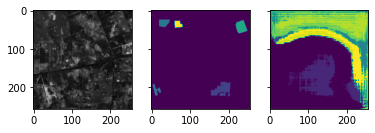

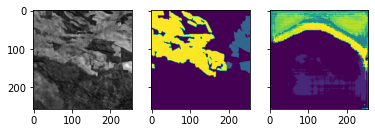

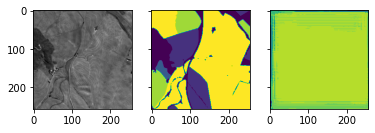

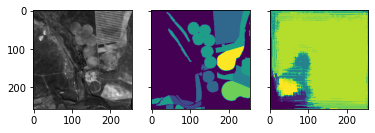

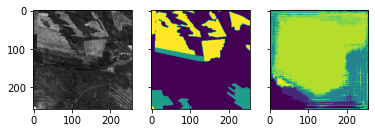

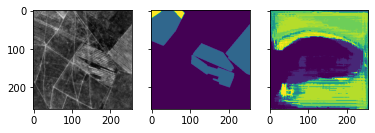

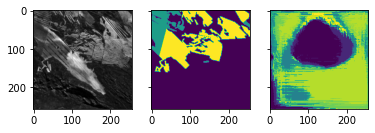

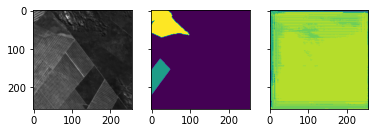

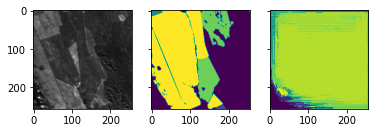

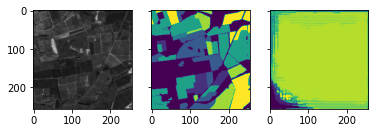

In [31]:
for i in range(10):
    visualize(*dataset[i]);

You might want to open up the "GPU Resources" tab from the `jupyyterlab-nvdashbard` extension to confirm that we're saturating the GPU.

Train it a bit longer.

In [32]:
%%time
with torch.cuda.device(0):
    for i in range(80):
        train_epoch.run(loader)
        print(i, end="\r\n")

train: 100%|██████████| 10/10 [00:01<00:00,  5.25it/s, cross_entropy_loss - 1.337, iou_score - 0.5633]
0
train: 100%|██████████| 10/10 [00:01<00:00,  5.59it/s, cross_entropy_loss - 1.149, iou_score - 0.7294]
1
train: 100%|██████████| 10/10 [00:01<00:00,  5.58it/s, cross_entropy_loss - 1.08, iou_score - 0.9789]
2
train: 100%|██████████| 10/10 [00:01<00:00,  5.61it/s, cross_entropy_loss - 1.042, iou_score - 0.8764]
3
train: 100%|██████████| 10/10 [00:01<00:00,  5.57it/s, cross_entropy_loss - 1.02, iou_score - 0.7344] 
4
train: 100%|██████████| 10/10 [00:01<00:00,  5.58it/s, cross_entropy_loss - 0.9831, iou_score - 0.6595]
5
train: 100%|██████████| 10/10 [00:01<00:00,  5.57it/s, cross_entropy_loss - 0.9431, iou_score - 0.6451]
6
train: 100%|██████████| 10/10 [00:01<00:00,  5.58it/s, cross_entropy_loss - 0.9031, iou_score - 0.7609]
7
train: 100%|██████████| 10/10 [00:01<00:00,  5.57it/s, cross_entropy_loss - 0.8793, iou_score - 1.121]
8
train: 100%|██████████| 10/10 [00:01<00:00,  5.54it/s

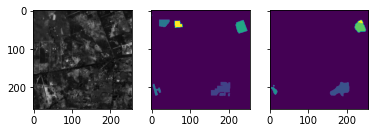

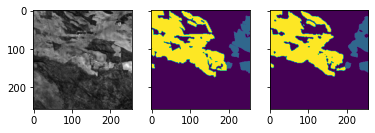

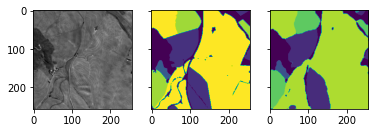

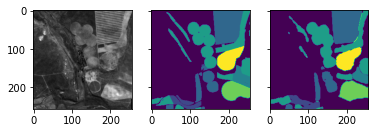

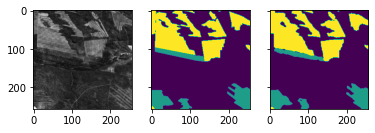

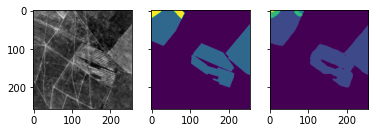

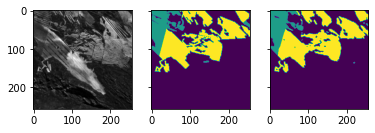

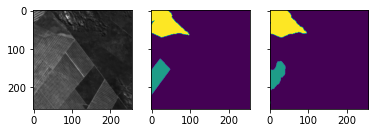

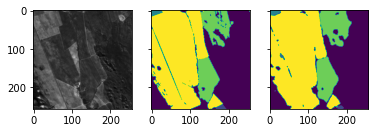

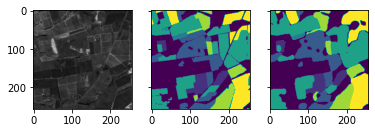

In [33]:
for i in range(10):
    visualize(*dataset[i]);

### Exercise: Play around!

In the remaining time, I encourage you to play around with the data preprocessing and model architecture. See what you can do.